In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *
import seaborn as sns
sns.set()
%matplotlib inline

#import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
print(torch.__version__)
os.chdir('../Data')

os.listdir()[:3]

0.4.0


['chr15.fa.fai', 'chr19.fa.fai', 'chr4.fa']

In [4]:
chromosomes = list(range(1,23)) + ['M','X','Y']
data_full = merge_chrom_data('chr', chromosomes)
print(data_full.shape)
print('not longer than 500bp:', sum(data_full.len <= 500) / data_full.shape[0])
data_full.len.describe()

['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10'
 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19'
 'chr20' 'chr21' 'chr22' 'chrM' 'chrX' 'chrY']
(8955, 5)
not longer than 500bp: 0.9711892797319933


count    8955.000000
mean      226.098157
std       132.413339
min         1.000000
25%       142.000000
50%       205.000000
75%       285.000000
max      5502.000000
Name: len, dtype: float64

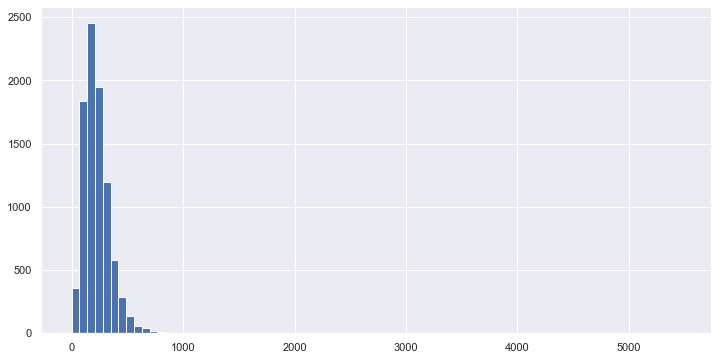

In [5]:
data_full.len.hist(bins=np.arange(data_full.len.min(),data_full.len.max(),70),figsize=(12,6))

In [6]:
# Center the sequences
def center_seq(max_seq_len = 500):
    gquad_places = pd.read_csv('G4_chip.bed', sep='\t', header=None, names = ['chr','start','end'])
    gquad_places['len'] = gquad_places.end - gquad_places.start
    print('Start shape:', gquad_places.shape)
    
    gquad_places['new_start'] = 0
    gquad_places['new_end'] = 0
    for i, row in gquad_places.iterrows():
        if row.len <= max_seq_len:
            shift_l = int((max_seq_len - row.len) / 2)
            shift_r = int((max_seq_len - row.len) / 2 + 0.5)
            gquad_places.loc[i,'new_start'] = row.start - shift_l
            gquad_places.loc[i,'new_end'] = row.end + shift_r
        else:
            gquad_places = gquad_places.drop(i, axis=0)
    print('Final shape:',gquad_places.shape)
    gquad_places[['chr','new_start','new_end']].to_csv('G4_chip_centered.bed', sep='\t',header=False, index = False)
    return gquad_places
center_seq(500).head()

Start shape: (8955, 4)
Final shape: (8697, 6)


,chr,start,end,len,new_start,new_end
0,chr1,713977,714310,333,713894,714394
1,chr1,762850,762982,132,762666,763166
2,chr1,840076,840205,129,839891,840391
3,chr1,894635,894796,161,894466,894966
4,chr1,935414,935699,285,935307,935807


In [7]:
# Load all data and merge chromosomes in 1 table
def merge_chrom_data(file_name_start, chromosomes, file_name_end = ''):
    columns = ['chr','start','end','seq']
    data = pd.DataFrame()
    for num in chromosomes:
        chrom = pd.read_csv(f'{file_name_start}{num}{file_name_end}.bed',sep='\t',header=None)
        data = pd.concat([data, chrom])
    data.columns=columns
    data = data.reset_index(drop=True)
    data['len'] = data.end - data.start

    print(data.chr.unique())
    return data

chromosomes = list(range(1,23)) + ['M','X','Y']
df = merge_chrom_data('chr', chromosomes, '_centered')
df.head()

['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10'
 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19'
 'chr20' 'chr21' 'chr22' 'chrM' 'chrX' 'chrY']


,chr,start,end,seq,len
0,chr1,713894,714394,TTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTCTTACCA...,500
1,chr1,762666,763166,ACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCTTCGGAG...,500
2,chr1,839891,840391,ACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAACGCGGCC...,500
3,chr1,894466,894966,GGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGCCCCAGC...,500
4,chr1,935307,935807,CTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGCGGCCAT...,500


In [13]:
df.drop('len',axis=1)

,chr,start,end,seq
0,chr1,713894,714394,TTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTCTTACCA...
1,chr1,762666,763166,ACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCTTCGGAG...
2,chr1,839891,840391,ACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAACGCGGCC...
3,chr1,894466,894966,GGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGCCCCAGC...
4,chr1,935307,935807,CTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGCGGCCAT...
5,chr1,935988,936488,CTGCTCGGTCTCCGAGTTTGATCCGACACCGGCTCGGCCTCCGGGG...
6,chr1,937062,937562,CCCCTGAGGCGCCCCCCACACCCCGCCGCTTGCACAGGGGCGCGGG...
7,chr1,940305,940805,AGGGGTCCTGTCCCCTCCCCACTTACCCCACTGGGTCCTTTCTCCC...
8,chr1,968300,968800,CGGACGGGCCCCTCCCTTACCCCCGGATCCCCCGGCTGGGCAGCGG...
9,chr1,976053,976553,GAATGCTGTGCGGCTTCGGCGCCGTGTGCGAGCCCAACGCGGAGGG...


In [55]:
for i, row in df.iterrows():
    if 'N' in row.seq:
        print(row.chr, row.seq)

chr3 TACAAGCATGTGTCCACACACGCACACACGCCTCTCTCCGGATAAAGAGGTCTCGGGGTGAGGATTCTGGAACCCGTCCTTCCACACCTACTGCGTCTGGTCACTGTCTCCGAGGCTGACATTCCTCACGCCGAGGGATGGGCAGGCAGAAGGCTGCAGGCAGTGCGCCAGCCAGGTCAGCTTACAGCGAGCTGTCAACCCAGTCACTGACGCCTCAGCGAGGCCATAAATAACAGCGGTGAAGCTGCAGCAGGCCACCCGGGCCTCCCCCAAACCACTCCTCTGCCATCAATCTCGCCTGATGACTGCTTGGCGTTCAGGCTTCCGCGTGACCCGACCACGGCCCCAAGCGTTCTTTGGGGCGCAGTGTCCCTTCCCAGGCACGGAGTGGGTCAGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
chr10 GGGGCCCATGACGCCGCCGGGGCGCGGGCGCTCCTCTGCCCAACTCTCGGCGGAACGCGGCTCCCGGCTCCTGTTCCTCTGCCGCCGCAGCCGCCGGCCCCGGCGCTGCCCGGTAGACAGAACCGAGCCGAAGAACAGCAGCAGCGGCGCCCCGCGCTCCCTGGGGCCCTGACGGCGACGGCGGNCccacctcctgcgcccccgccccctcccgccgtcctccagtcccctcagctgccgcgcgcgcgtcaccgccgcccgcaccgccgctgccgccgctactgAGCATGCCCAGAGGCCGTCCAACGGGATTCCGGCCCCCCAAGTCAGCGGGGCGGGCGCGCCGTGCTGCCAGGACCTGGCGACGGCGACAGGGATAGGGCGAGCGCACCCCTGTTTCTTCTCACCCCCACCCCGCGGGCATTTCGAAGTCACGCGTGCTGCTGTGGCCTCATTCATTCAACACGCTTCTCAGCGCGTCAGCTCAG

In [138]:
# Center the sequences
# def center_seq(df, max_seq_len = 500):
#     df['seq_centered'] = ''
#     for i, row in df.iterrows():
#         if row.len < max_seq_len:
#             shift_l = int((max_seq_len - row.len) / 2)
#             shift_r = int((max_seq_len - row.len) / 2 + 0.5)
#             new_seq = 'N' * shift_l + row.seq + 'N' * shift_r
#             df.loc[i,'seq_centered'] = new_seq
#         else:
#             df.loc[i,'seq_centered'] = row.seq
#     return df
# df = center_seq(df)

In [36]:
# Load shuffled data, drop sequences longer than 500, center sequences
chromosomes = list(range(1,23)) + ['M','X','Y']
shuf = merge_chrom_data('shuffled_chr', chromosomes)
shuf.head()

['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10'
 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19'
 'chr20' 'chr21' 'chr22' 'chrM' 'chrX' 'chrY']


,chr,start,end,seq,len
0,chr1,113133816,113134316,tgctgggattacaggtgtgagccaccacacccggccTAGTATGTTA...,500
1,chr1,180867994,180868494,ctttaaaatgcctttggtcccaagtctctgacaggagggtgaggtg...,500
2,chr1,95276940,95277440,gggcaaagaacccgcatcagcctgcctcatcattaaccctcaactg...,500
3,chr1,40094551,40095051,gcgtgagccaccgcgcccggccCGCTGTTTTTTTCTAACATTTGCT...,500
4,chr1,152882574,152883074,CAGAAAACCCAGAGCAGCAGCTTAAGCAGGAGAAAACACAAAGGGA...,500


In [54]:
calc = {}
for i, row in shuf.iterrows():
    if 'N' in row.seq:
        if row.chr not in calc:
            calc[row.chr]=1
        else:
            calc[row.chr]+=1
print(calc)

{'chr1': 96, 'chr2': 5, 'chr3': 8, 'chr4': 3, 'chr5': 9, 'chr6': 8, 'chr7': 10, 'chr8': 6, 'chr9': 45, 'chr10': 5, 'chr11': 16, 'chr12': 9, 'chr13': 11, 'chr14': 26, 'chr15': 43, 'chr16': 62, 'chr17': 26, 'chr18': 9, 'chr19': 57, 'chr20': 7, 'chr21': 31, 'chr22': 75, 'chrX': 4, 'chrY': 3}


In [56]:
# Split to test & train
test_chromosomes_list = [3,6,9,12,15,18,21]
test_chromosomes = list(map(lambda n:'chr'+str(n),test_chromosomes_list))
specific_chromosomes = ['chrX','chrM','chrY']

shuf['label'] = 0
test_shuf = shuf[shuf.chr.isin(test_chromosomes)]
train_shuf = shuf[~shuf.chr.isin(test_chromosomes + specific_chromosomes)]

df['label'] = 1
test_data = df[df.chr.isin(test_chromosomes)]
train_data = df[~df.chr.isin(test_chromosomes + specific_chromosomes)]

train = pd.concat([train_data,train_shuf]).reset_index(drop=True)
test = pd.concat([test_data,test_shuf]).reset_index(drop=True)

In [57]:
def encode_seq(sequences):
    encoder = {'A':[0,0,0,1],'T':[0,0,1,0],'G':[0,1,0,0],'C':[1,0,0,0],'N':[0,0,0,0]}
    
    encoded_seqs = []
    for seq in sequences:
        encoded_seq = list(map(lambda nucl: encoder[nucl], seq.upper()))
        encoded_seqs.append(encoded_seq)
    return encoded_seqs

In [59]:
# Shuffle train & test
#train = train.sample(frac=1,random_state=42).reset_index(drop=True)
#test = test.sample(frac=1,random_state=42).reset_index(drop=True)

# Get X & y
train_X = encode_seq(train.seq)#.to_list()
test_X = encode_seq(test.seq)#.to_list()
train_y = train.label#.to_list()
test_y = test.label#.to_list()

In [60]:
np.array(test_y).shape

(4222,)

In [62]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

class SimpleSeqsDataset(Dataset):
    def __init__(self, seqs, labels=None, transforms=None):
        self.X = seqs
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i]
        data = np.asarray(data)
        
        data = torch.from_numpy(data).type(torch.FloatTensor).permute(1,0)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
        
BATCH_SIZE = 32
#transform = transforms.Compose([transforms.ToTensor()])
     
     
train_dataset = SimpleSeqsDataset(train_X, train_y)
test_dataset = SimpleSeqsDataset(test_X, test_y)

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=True)

len(train_X)//BATCH_SIZE

401

In [65]:
train_dataset.__getitem__(3)[0]

tensor([[ 0.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 1.,  1.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  1.,  1.]])

In [66]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4,out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool1d(5)
        self.fc1 = nn.Linear(16*99, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.size())
        x = self.pool(x)
        #print(x.size())
        x = x.view(-1, 16*99)
        x = F.relu(self.fc1(x))
        #print(x.size())
        x = F.sigmoid(self.fc2(x))
        return x


net = Net()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print(net)

Net(
  (conv1): Conv1d(4, 16, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1584, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [67]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

# Train 
for epoch in range(3):  

    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].type(torch.FloatTensor).unsqueeze(1).to(device) #non_blocking=True)
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #print(f'Input:{inputs.size()}\n')
        outputs = net(inputs)
        #print(outputs)
        #print(f'\nOutput:{outputs.size()}')
        loss = criterion(outputs, labels)
        acc = binary_acc(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc.item()
        if i % 100 == 99:    
            print('[%d, %5d] loss: %.3f acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100, running_acc / 100))
            running_loss = 0.0
            running_acc = 0.0

print('Finished Training')

[1,   100] loss: 0.650 acc: 71.140
[1,   200] loss: 0.484 acc: 88.700
[1,   300] loss: 0.295 acc: 90.150
[1,   400] loss: 0.217 acc: 91.600
[2,   100] loss: 0.201 acc: 93.820
[2,   200] loss: 0.181 acc: 93.890
[2,   300] loss: 0.192 acc: 93.400
[2,   400] loss: 0.172 acc: 94.090
[3,   100] loss: 0.180 acc: 94.030
[3,   200] loss: 0.174 acc: 93.680
[3,   300] loss: 0.159 acc: 94.430
[3,   400] loss: 0.164 acc: 94.390
Finished Training


In [68]:
# Test
def test(net, test_loader):
    y_pred_list = []
    y_labels_list=[]
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device) #non_blocking=True)
            outputs = net(inputs)
            #print(outputs)
            outputs = torch.round(outputs)
            y_pred_list.append(outputs.cpu().numpy())
            y_labels_list.append(labels.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_labels_list = [a.squeeze().tolist() for a in y_labels_list]
    return(y_labels_list, y_pred_list)
        
y_labels_list, y_pred_list = test(net, test_loader)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2111
           1       0.97      0.93      0.95      2111

    accuracy                           0.95      4222
   macro avg       0.95      0.95      0.95      4222
weighted avg       0.95      0.95      0.95      4222



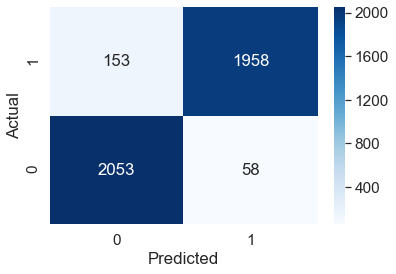

<Figure size 720x720 with 0 Axes>

In [70]:
def plot_conf_matrix(y_true, y_pred):
    print(classification_report(y_labels_list, y_pred_list))
    cf = pd.DataFrame(confusion_matrix(y_true, y_pred))
    ax= plt.subplot()
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1.4)

    sns.heatmap(cf, annot=True, ax = ax,cmap='Blues',fmt='d')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_ylim([0,2])
plot_conf_matrix(y_labels_list, y_pred_list)

In [464]:
roc_auc_score(y_labels_list, y_pred_list)

0.9488394126006632